<a href="https://colab.research.google.com/github/vinaykumargummadi/DSML/blob/main/Deep%20Learning/notebooks/NLP/Automatic_Ticket_Classification_using_NMF_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Vinay Kumar Gummadi |
gummadivinaykumar18@gmail.com  
**Project Name:** Automatic Ticket Classification using NMF - NN

In [51]:
import numpy as np
import pandas as pd
from scipy.stats import randint

import json

import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

from tqdm import tqdm
tqdm.pandas()

In [52]:
pd.reset_option("display.max_rows")
pd.reset_option("display.max_columns")

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**1. Reading JSON Data:**
- Load the JSON data containing text documents.
- Extract relevant fields from the JSON data.

In [86]:
json_path='/content/drive/MyDrive/01. DSML_ML Algorithms/Algorithms/data/complaints-2021-05-14_08_16.json'
with open(json_path,'r') as f:
  data=json.load(f)
df=pd.json_normalize(data)

In [87]:
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [88]:
np.round((df.isnull().sum())/len(df)*100,2)

_index                                0.00
_type                                 0.00
_id                                   0.00
_score                                0.00
_source.tags                         86.08
_source.zip_code                      8.63
_source.complaint_id                  0.00
_source.issue                         0.00
_source.date_received                 0.00
_source.state                         2.54
_source.consumer_disputed             0.00
_source.product                       0.00
_source.company_response              0.00
_source.company                       0.00
_source.submitted_via                 0.00
_source.date_sent_to_company          0.00
_source.company_public_response      99.99
_source.sub_product                  13.50
_source.timely                        0.00
_source.complaint_what_happened       0.00
_source.sub_issue                    59.12
_source.consumer_consent_provided     1.29
dtype: float64

In [89]:
df['_source.tags'].value_counts()

Older American                   6103
Servicemember                    3759
Older American, Servicemember    1038
Name: _source.tags, dtype: int64

In [90]:
df['_source.product'].value_counts()

Mortgage                                                                        22725
Checking or savings account                                                     12147
Credit card or prepaid card                                                     10797
Credit card                                                                     10373
Bank account or service                                                          9816
Credit reporting, credit repair services, or other personal consumer reports     4310
Debt collection                                                                  3201
Money transfer, virtual currency, or money service                               1500
Consumer Loan                                                                    1029
Vehicle loan or lease                                                             892
Student loan                                                                      866
Money transfers                                       

In [91]:
df['_source.sub_product'].value_counts()

Checking account                              17182
General-purpose credit card or charge card    10504
Other mortgage                                 8447
Conventional fixed mortgage                    4892
Credit reporting                               4172
                                              ...  
Gift or merchant card                             4
Government benefit payment card                   4
ID prepaid card                                   2
Medical debt                                      2
Electronic Benefit Transfer / EBT card            1
Name: _source.sub_product, Length: 72, dtype: int64

In [92]:
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [93]:
df=df[['_source.product','_source.sub_product','_source.complaint_what_happened']]
df=df.rename(columns={'_source.product':"product",'_source.sub_product':"sub_product",'_source.complaint_what_happened':"complaint"})
df.head()

,product,sub_product,complaint
0,Debt collection,Credit card debt,
1,Debt collection,Credit card debt,Good morning my name is XXXX XXXX and I apprec...
2,Credit card or prepaid card,General-purpose credit card or charge card,I upgraded my XXXX XXXX card in XX/XX/2018 and...
3,Mortgage,Conventional home mortgage,
4,Credit card or prepaid card,General-purpose credit card or charge card,


In [94]:
df['product']=df['product']+" + "+df['sub_product']
df=df.drop(['sub_product'],axis=1)
df.head()

,product,complaint
0,Debt collection + Credit card debt,
1,Debt collection + Credit card debt,Good morning my name is XXXX XXXX and I apprec...
2,Credit card or prepaid card + General-purpose ...,I upgraded my XXXX XXXX card in XX/XX/2018 and...
3,Mortgage + Conventional home mortgage,
4,Credit card or prepaid card + General-purpose ...,


In [95]:
df.head()

,product,complaint
0,Debt collection + Credit card debt,
1,Debt collection + Credit card debt,Good morning my name is XXXX XXXX and I apprec...
2,Credit card or prepaid card + General-purpose ...,I upgraded my XXXX XXXX card in XX/XX/2018 and...
3,Mortgage + Conventional home mortgage,
4,Credit card or prepaid card + General-purpose ...,


In [96]:
df[df.complaint == ''] = np.nan

In [97]:
df.isnull().sum()

product      59350
complaint    57241
dtype: int64

In [98]:
df = df[~df['complaint'].isnull()]
df.complaint.isnull().sum()

0

In [99]:
df.shape

(21072, 2)

In [100]:
import string
import nltk
import spacy

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [101]:
nlp = spacy.load("en_core_web_sm")

In [102]:
text=df.complaint.sample(1).values
text=text[0]
text

"On XX/XX/XXXX the governor of Florida  declared Florida a disaster area before the hurricane arrived on XX/XX/XXXX. I live in XXXX XXXX County. JPMorgan Chase & Co. is my servicing lender. On Tuesday, XX/XX/XXXX I notified Chase that I would like a forberance. I have a XXXX  XXXX ( FHA ) loan and XXXX XXXX authorized lenders to either reduce or suspend payments. On XX/XX/XXXX, I received a letter from Chase stating I am receiving payment assistance as part of the disaster relief program. In the letter Chase stated, that I would receive statements but I am not required to make monthly payments. They encouraged me to pay some amount each month. Please read the letter dated XX/XX/XXXX in attachment # 1. \nOn Thursday, XX/XX/XXXX I took my flood check to Chase, please see the attachment # 2 a  copy of the FEMA FLOOD check for {$1.00}, XXXX which someone in the bank endorsed the check. Then on Friday, XX/XX/XXXX, I went to the same local  branch on XXXX XXXX XXXX XXXX on XXXX XXXX in XXXX 

**2. Data Preprocessing and Cleaning:**
- Clean the text data by removing noise such as special characters, and punctuation.
- Convert text to lowercase to ensure consistency.
- Tokenize the text data into words or phrases for further analysis.

In [103]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def pre_processing_text(text):
  cleaned_token=[]
  doc=nlp(text)
  tokens = [token.text for token in doc]
  for token in tokens:
    token_lower=token.lower()
    if token_lower not in stop_words and token_lower.isalpha() and token_lower not in ['xx','xxxx']:
      token_lower=token_lower.strip()
      cleaned_token.append(token_lower)

  cleaned_text=' '.join(cleaned_token)

  return cleaned_text

In [104]:
df['processed_complaint']=df.complaint.progress_apply(pre_processing_text)

100%|██████████| 21072/21072 [20:23<00:00, 17.22it/s]


In [105]:
pd.set_option("display.max_colwidth", None)

In [106]:
df.head()

,product,complaint,processed_complaint
1,Debt collection + Credit card debt,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning name appreciate could help put stop chase bank cardmember services wrote chase asking debt verification sent statement acceptable asking bank validate debt instead receiving mail every month attempting collect debt right know information consumer chase account thanks advance help
2,Credit card or prepaid card + General-purpose credit card or charge card,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,upgraded card told agent upgrade anniversary date would change turned agent giving wrong information order upgrade account changed anniversary date without consent recording agent misled
10,"Credit reporting, credit repair services, or other personal consumer reports + Other personal consumer report","Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card reported however fraudulent application submitted identity without consent fraudulently obtain services extend credit without verifying identity applicant
11,"Credit reporting, credit repair services, or other personal consumer reports + Credit reporting","On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the application be withdrawn and the representative obliged. This all happened no later than 10mins after putting in the application on XX/XX/2018. Notwithstanding my explicit request not to proceed with the application and contrary to what I was told by the Chase representative, Chase did in fact go ahead to open a credit account in my name on XX/XX/2018. This is now being reported in my Credit Report and Chase has refused to correct this information on my credit report even though they went ahead to process an application which I did not consent to and out of their error.",trying book ticket came across offer applied towards ticket applied rewards card put information offer within less minute notified via screen decision could made immediately contacted referred chase bank immediately contacted chase bank within getting notification screen told chase representative spoke application denied could state asked information offer explained even approved credit offer gets applied fir

In [107]:
sample='good morning name appreciate could help put stop chase bank cardmember services wrote chase asking debt verification sent statement acceptable asking bank validate debt instead receiving mail every month attempting collect debt right know information consumer chase account thanks advance help'

**3. Noun Extraction:**
- Use NLP techniques to extract nouns from the preprocessed text data.
- Nouns often represent important entities or concepts in the text and can be useful for topic modeling.

In [108]:
def get_nouns(text):
  doc = nlp(text)
  nouns=[token.text for token in doc if token.pos_ == 'NOUN']
  return " ".join(nouns)

In [109]:
df['Lemma_Nouns']=df.processed_complaint.progress_apply(get_nouns)

100%|██████████| 21072/21072 [09:39<00:00, 36.35it/s]


In [110]:
import spacy

# Load English language model
nlp = spacy.load("en_core_web_sm")

# Sample text
sample_text = 'good morning name appreciate could help put stop chase bank cardmember services wrote chase asking debt verification sent statement acceptable asking bank validate debt instead receiving mail every month attempting collect debt right know information consumer chase account thanks advance help'

# Process the sample text
doc = nlp(sample_text)

# Extract nouns from the text
nouns = [token.text for token in doc if token.pos_ == 'NOUN']

print("Nouns extracted from the sample text:")
print(nouns)


Nouns extracted from the sample text:
['morning', 'name', 'appreciate', 'bank', 'services', 'chase', 'debt', 'verification', 'statement', 'bank', 'validate', 'debt', 'mail', 'month', 'collect', 'debt', 'information', 'consumer', 'chase', 'account', 'thanks', 'advance', 'help']


In [111]:
df.head()

,product,complaint,processed_complaint,Lemma_Nouns
1,Debt collection + Credit card debt,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning name appreciate could help put stop chase bank cardmember services wrote chase asking debt verification sent statement acceptable asking bank validate debt instead receiving mail every month attempting collect debt right know information consumer chase account thanks advance help,morning name appreciate bank services chase debt verification statement bank validate debt mail month collect debt information consumer chase account thanks advance help
2,Credit card or prepaid card + General-purpose credit card or charge card,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,upgraded card told agent upgrade anniversary date would change turned agent giving wrong information order upgrade account changed anniversary date without consent recording agent misled,card agent upgrade anniversary date agent information order upgrade account anniversary date consent recording agent
10,"Credit reporting, credit repair services, or other personal consumer reports + Other personal consumer report","Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card reported however fraudulent application submitted identity without consent fraudulently obtain services extend credit without verifying identity applicant,card application identity consent services credit identity applicant
11,"Credit reporting, credit repair services, or other personal consumer reports + Credit reporting","On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the application be withdrawn and the representative obliged. This all happened no later than 10mins after putting in the application on XX/XX/2018. Notwithstanding my explicit request not to proceed with the application and contrary to what I was told by the Chase representative, Chase did in fact go ahead to open a credit account in my name on XX/XX/2018. This is now being reported in my Credit Report and Chase has refused to correct this information on my credit report even though they went ahead to process an application which I did not consent to and out of their error.",trying book ticket came across offer applied

In [112]:
nouns_corpus=df.Lemma_Nouns.to_list()

In [113]:
noun_corpus_str=[''.join(noun_str) for noun_str in nouns_corpus]

In [114]:
# noun_corpus_str=['morning name appreciate bank services chase debt verification statement bank validate debt mail month collect debt information consumer chase account thanks advance help',
#  'card agent upgrade anniversary date agent information order upgrade account anniversary date consent recording agent',
#  'card application identity consent services credit identity applicant',
#  'book ticket offer ticket rewards card information offer minute screen decision chase bank chase bank notification screen application state information offer credit offer account statement purchase ticket account application representative application request proceed application chase fact credit account name credit report chase information credit report process application consent error',
#  'son check deposit chase account fund account money son money chase bank money son call verify check owner country check number claim number chase',
#  'inquiry',
#  'account debit card branch customer service representative account branch funds deposit place employment bank customer service representative funds business day branch funds account funds statement business day date funds bank teller chase check business days funds account bind fees rent car payments notice things peace mind fact chase situation bank teller inform account look chase reserves account time notice form document notice things peace mind fact chase situation bank teller inform account look chase reserves account time notice form document situation livelihood deal',
#  'summer months experience decline income employment month payment extension auto loan company chase fours years payment extension auto loan payment month payment extension year representative supervisor discussion reason reason denial office executive director communications chase follow week office role matter representative conference call department handing request information request policy changes explanation representative letter explanation letters reason policy changes cfpb help payment extension request reason denial']

**4. Feature Engineering:**
- Extract relevant features from the text data, such as word frequency, TF-IDF scores, or word embeddings.
- Perform additional preprocessing steps like stopword removal and stemming/lemmatization to enhance the quality of features.

In [115]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_df=0.95)

X = vectorizer.fit_transform(noun_corpus_str)

In [116]:
from sklearn.decomposition import NMF
num_topics = 5
nmf_model = NMF(n_components=num_topics,random_state=42)
nmf_matrix=nmf_model.fit_transform(X)

In [117]:
feature_names = vectorizer.get_feature_names_out()
topic_words = []
feature_names

array(['aaa', 'aacount', 'aand', ..., 'zones', 'zoo', 'zoom'],
      dtype=object)

In [118]:
nmf_model.components_

array([[0.00000000e+00, 6.91220905e-05, 0.00000000e+00, ...,
        9.56441361e-05, 2.14513002e-04, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.15107907e-03, 9.01539913e-05, 6.24087914e-05, ...,
        1.92533212e-04, 0.00000000e+00, 1.51093214e-03],
       [2.48205143e-03, 0.00000000e+00, 3.78238163e-05, ...,
        1.95095849e-03, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 3.57378354e-04, ...,
        4.93301784e-04, 1.85989156e-04, 7.91468674e-04]])

**5. Topic Modeling with NMF:**
- Apply Non-negative Matrix Factorization (NMF) to the feature matrix derived from the text data.
- NMF helps identify latent topics present in the text corpus by decomposing it into topic-word and document-topic matrices.

In [119]:
for topic_indx,topic in enumerate(nmf_model.components_):
  top_n_indices = topic.argsort()[:-11:-1]
  topic_words.append([feature_names[i] for i in top_n_indices])

In [120]:
for idx, words in enumerate(topic_words):
    print(f"Topic {idx + 1}: {words}")

Topic 1: ['chase', 'letter', 'dispute', 'fraud', 'charge', 'phone', 'call', 'case', 'time', 'email']
Topic 2: ['credit', 'report', 'information', 'consumer', 'reporting', 'account', 'debt', 'payment', 'collection', 'score']
Topic 3: ['account', 'bank', 'money', 'check', 'funds', 'branch', 'number', 'deposit', 'days', 'business']
Topic 4: ['loan', 'payment', 'mortgage', 'payments', 'time', 'interest', 'home', 'modification', 'bank', 'property']
Topic 5: ['card', 'credit', 'charges', 'purchase', 'charge', 'fraud', 'time', 'debit', 'cards', 'fee']


In [121]:
topic_numbers = {0: 'Theft/Dispute reporting',
                 1: 'Credit card / Prepaid card',
                 2: 'Bank account services',
                 3: 'Mortgages/loans',
                 4: 'Other'}

In [122]:
df['Topic'] = [topic_numbers[idx] for idx in nmf_matrix.argmax(axis=1)]

In [123]:
df.head()

,product,complaint,processed_complaint,Lemma_Nouns,Topic
1,Debt collection + Credit card debt,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning name appreciate could help put stop chase bank cardmember services wrote chase asking debt verification sent statement acceptable asking bank validate debt instead receiving mail every month attempting collect debt right know information consumer chase account thanks advance help,morning name appreciate bank services chase debt verification statement bank validate debt mail month collect debt information consumer chase account thanks advance help,Theft/Dispute reporting
2,Credit card or prepaid card + General-purpose credit card or charge card,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,upgraded card told agent upgrade anniversary date would change turned agent giving wrong information order upgrade account changed anniversary date without consent recording agent misled,card agent upgrade anniversary date agent information order upgrade account anniversary date consent recording agent,Bank account services
10,"Credit reporting, credit repair services, or other personal consumer reports + Other personal consumer report","Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card reported however fraudulent application submitted identity without consent fraudulently obtain services extend credit without verifying identity applicant,card application identity consent services credit identity applicant,Credit card / Prepaid card
11,"Credit reporting, credit repair services, or other personal consumer reports + Credit reporting","On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the application be withdrawn and the representative obliged. This all happened no later than 10mins after putting in the application on XX/XX/2018. Notwithstanding my explicit request not to proceed with the application and contrary to what I was told by the Chase representative, Chase did in fact go ahead to open a credit account in my name on XX/XX/2018. This is now being reported in my Credit Report and Chase has refused to correct this information on my credit report even though they went ahead to process an application which I did not c

In [ ]:
df.to_csv("/content/drive/MyDrive/01. DSML_ML Algorithms/Algorithms/data/complaints-2021-05-14_08_16.csv")

In [55]:
df=pd.read_csv("/content/drive/MyDrive/01. DSML_ML Algorithms/Algorithms/data/complaints-2021-05-14_08_16.csv")

In [56]:
df.Topic.value_counts()

Bank account services         6309
Theft/Dispute reporting       4483
Credit card / Prepaid card    3694
Mortgages/loans               3648
Other                         2938
Name: Topic, dtype: int64

**6 Model Building**

**6.1 Logistic Regression:**
- Train a logistic regression classifier using the preprocessed text data.
- Tune hyperparameters such as regularization strength (C) using techniques like cross-validation.
- Evaluate the model's performance using appropriate metrics such as accuracy, precision, recall, and F1-score.

In [57]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer

count_vector=CountVectorizer(max_df=0.95,ngram_range=(1,2))
X_count_vector=count_vector.fit_transform(df['processed_complaint'])

In [58]:
Tf_Idf_vector=TfidfTransformer()
X=Tf_Idf_vector.fit_transform(X_count_vector)

In [59]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [60]:
encoder_obj = LabelEncoder()
Y=encoder_obj.fit_transform(df.Topic)

In [62]:
Y

array([4, 0, 1, ..., 4, 4, 1])

In [63]:
X_train,X_test,y_train,y_test = train_test_split(X,Y)

In [64]:
num_folds = 5

cv = StratifiedKFold(n_splits=num_folds,shuffle=True,random_state=58)

In [65]:
LR_model = LogisticRegression(max_iter=1000)

In [66]:
%%time
accuracy_lr=[]
for fold,(train_idx,val_idx) in  enumerate(cv.split(X_train,y_train)):
  # print(fold,train_idx,val_idx)
  X_train_fold,X_Val_fold = X_train[train_idx],X_train[val_idx]
  y_train_fold,y_Val_fold = y_train[train_idx],y_train[val_idx]
  LR_model.fit(X_train_fold,y_train_fold)
  y_pred_fold = LR_model.predict(X_Val_fold)
  fold_accuracy=accuracy_score(y_Val_fold,y_pred_fold)
  accuracy_lr.append(fold_accuracy)
  print(f'Fold {fold+1} is having accuracy of: {fold_accuracy:.4f}')

Fold 1 is having accuracy of: 0.8434
Fold 2 is having accuracy of: 0.8529
Fold 3 is having accuracy of: 0.8551
Fold 4 is having accuracy of: 0.8497
Fold 5 is having accuracy of: 0.8513
CPU times: user 12min 24s, sys: 5min 15s, total: 17min 40s
Wall time: 14min 19s


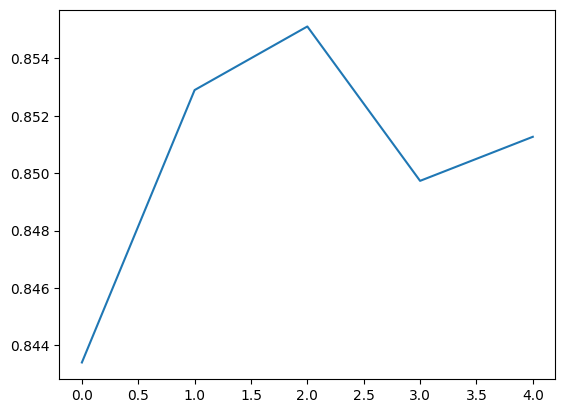

In [67]:
plt.plot(accuracy_lr)
plt.show()

**6.2 Naive Bayes:**
- Implement a Naive Bayes classifier, such as Multinomial Naive Bayes, for text classification.
- Tune hyperparameters, if necessary, and evaluate the model using cross-validation.

In [68]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

In [69]:
mnb = MultinomialNB()

In [70]:
param_grid = {'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001)}
grid_search = GridSearchCV(mnb, param_grid=param_grid,cv=cv,scoring='accuracy',n_jobs=-1)

In [71]:
%%time
grid_search.fit(X_train,y_train)

CPU times: user 644 ms, sys: 243 ms, total: 887 ms
Wall time: 14.6 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=58, shuffle=True),
             estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 1e-05)},
             scoring='accuracy')

In [72]:
results_df=pd.DataFrame(grid_search.cv_results_)
best_idx = results_df['mean_test_score'].idxmax()
best_fold_accuracies_Navie_bayes = []
for fold in range(5):
    fold_accuracy = results_df[f'split{fold}_test_score'][best_idx]
    best_fold_accuracies_Navie_bayes.append(fold_accuracy)

In [73]:
best_fold_accuracies_Navie_bayes

[0.6665612148054413,
 0.6618158810503005,
 0.6665612148054413,
 0.6709901929769061,
 0.6699367088607595]

**6.3 Random Forest:**
- Train a Random Forest classifier on the text data.
- Optimize hyperparameters like the number of trees and maximum depth using techniques like grid search or randomized search.
- Assess the model's performance using cross-validation and evaluation metrics.

In [74]:
from sklearn.ensemble import RandomForestClassifier

In [75]:
param_grid={
    'n_estimators': [1,10,100],
    'criterion':["gini", "entropy", "log_loss"],
    'max_depth':[1,3,5,9]
}

In [76]:
clf = RandomForestClassifier()
grid_search_rmf = GridSearchCV(clf, param_grid=param_grid,cv=cv,scoring='accuracy',n_jobs=-1)

In [77]:
%%time
grid_search_rmf.fit(X_train,y_train)

CPU times: user 6.92 s, sys: 1.2 s, total: 8.12 s
Wall time: 7min 5s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=58, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [1, 3, 5, 9],
                         'n_estimators': [1, 10, 100]},
             scoring='accuracy')

In [78]:
results_rmf_df=pd.DataFrame(grid_search_rmf.cv_results_)
best_idx = results_rmf_df['mean_test_score'].idxmax()
best_fold_accuracies_Random_forest = []
for fold in range(5):
    fold_accuracy = results_rmf_df[f'split{fold}_test_score'][best_idx]
    best_fold_accuracies_Random_forest.append(fold_accuracy)

In [79]:
best_fold_accuracies_Random_forest

[0.34071496361910786,
 0.33691869661499524,
 0.34134767478646,
 0.33976589686807973,
 0.3996835443037975]

In [80]:
accuracy_df = pd.DataFrame({
    'Logistic Regression': accuracy_lr,
    'Naive Bayes': best_fold_accuracies_Navie_bayes,
    'Random Forest': best_fold_accuracies_Random_forest
})

In [81]:
accuracy_df

,Logistic Regression,Naive Bayes,Random Forest
0,0.843404,0.666561,0.340715
1,0.852895,0.661816,0.336919
2,0.855109,0.666561,0.341348
3,0.849731,0.670990,0.339766
4,0.851266,0.669937,0.399684


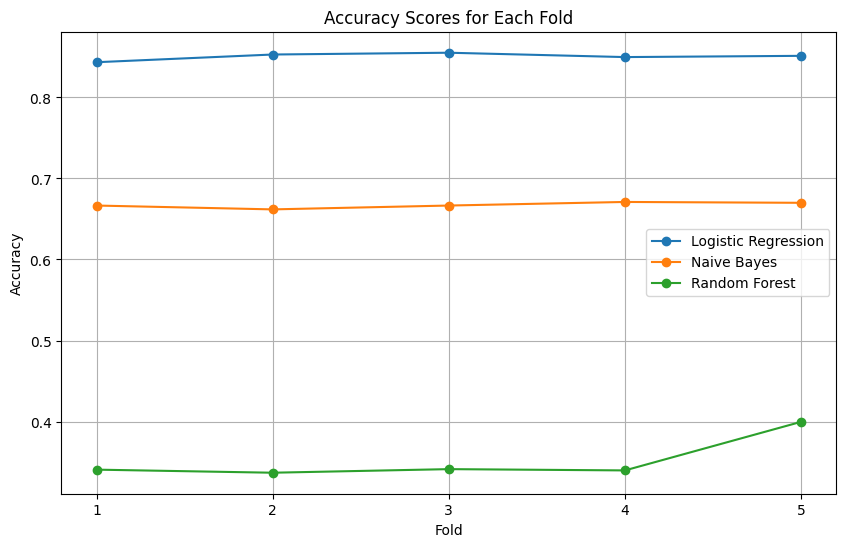

In [83]:
folds = [1, 2, 3, 4, 5]
plt.figure(figsize=(10, 6))
plt.plot(folds, accuracy_df['Logistic Regression'], marker='o', label='Logistic Regression')
plt.plot(folds, accuracy_df['Naive Bayes'], marker='o', label='Naive Bayes')
plt.plot(folds, accuracy_df['Random Forest'], marker='o', label='Random Forest')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Accuracy Scores for Each Fold')
plt.xticks(folds)
plt.legend()
plt.grid(True)
plt.show()

In [84]:
accuracy_df

,Logistic Regression,Naive Bayes,Random Forest
0,0.843404,0.666561,0.340715
1,0.852895,0.661816,0.336919
2,0.855109,0.666561,0.341348
3,0.849731,0.670990,0.339766
4,0.851266,0.669937,0.399684


In [85]:
# Calculate average accuracy for each model
avg_accuracy_lr = accuracy_df['Logistic Regression'].mean()
avg_accuracy_nb = accuracy_df['Naive Bayes'].mean()
avg_accuracy_rf = accuracy_df['Random Forest'].mean()

print("Average Accuracy for Logistic Regression:", avg_accuracy_lr)
print("Average Accuracy for Naive Bayes:", avg_accuracy_nb)
print("Average Accuracy for Random Forest:", avg_accuracy_rf)

Average Accuracy for Logistic Regression: 0.8504809405772088
Average Accuracy for Naive Bayes: 0.6671730424997697
Average Accuracy for Random Forest: 0.35168615523848806


**Conclusion:**  
Considering its interpretability, efficiency, robustness, scalability, and performance, logistic regression stands out as the optimal choice for our classification task. Its ability to balance simplicity with effectiveness makes it a reliable model for making accurate predictions while maintaining model transparency and ease of implementation.